In [6]:
# Summer 2022
!java -version

#Install Spark
#download file
!wget -q http://apache.osuosl.org/spark/spark-3.4.4/spark-3.4.4-bin-hadoop3.tgz
#extract the file
!tar xf spark-3.4.4-bin-hadoop3.tgz
#install findspark package
!pip install -q findspark

import os
os.environ["SPARK_HOME"] = "/content/spark-3.4.4-bin-hadoop3"

openjdk version "11.0.25" 2024-10-15
OpenJDK Runtime Environment (build 11.0.25+9-post-Ubuntu-1ubuntu122.04)
OpenJDK 64-Bit Server VM (build 11.0.25+9-post-Ubuntu-1ubuntu122.04, mixed mode, sharing)


In [7]:
import findspark
findspark.init()

In [8]:
# create entry points to spark
try:
    sc.stop()
except:
    pass
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
conf = SparkConf().setAppName("Lab4").setMaster("local[*]")#local[2]
sc=SparkContext(conf = conf)
spark = SparkSession(sparkContext=sc)

In [9]:
!ls

sample_data  spark-3.4.4-bin-hadoop3  spark-3.4.4-bin-hadoop3.tgz


In [10]:
#!wget -O "Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments.csv" https://data.cityofchicago.org/api/views/n4j6-wkkf/rows.csv?accessType=DOWNLOAD #Traffic
!wget -O "Traffic_Crashes_-_Crashes.csv"  https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv?accessType=DOWNLOAD #Crashes

--2024-11-12 23:35:26--  https://data.cityofchicago.org/api/views/85ca-t3if/rows.csv?accessType=DOWNLOAD
Resolving data.cityofchicago.org (data.cityofchicago.org)... 100.28.82.57, 35.170.133.124, 174.129.43.10
Connecting to data.cityofchicago.org (data.cityofchicago.org)|100.28.82.57|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘Traffic_Crashes_-_Crashes.csv’

Traffic_Crashes_-_C     [       <=>          ] 460.48M  6.02MB/s    in 80s     

2024-11-12 23:36:47 (5.76 MB/s) - ‘Traffic_Crashes_-_Crashes.csv’ saved [482848105]



In [11]:
#!wget -O "Chicago_Traffic_Tracker_-_Historical_Congestion_Estimates_by_Segment.csv" https://data.cityofchicago.org/api/views/sxs8-h27x/rows.csv?accessType=DOWNLOAD #Congestion

In [12]:
#Read in Files
# dfTraffic = spark.read.option('header','true').csv('Chicago_Traffic_Tracker_-_Congestion_Estimates_by_Segments.csv',inferSchema = True)
dfCrashes = spark.read.option('header','true').csv('Traffic_Crashes_-_Crashes.csv',inferSchema = True)

# dfTraffic documentation: https://data.cityofchicago.org/Transportation/Chicago-Traffic-Tracker-Congestion-Estimates-by-Se/n4j6-wkkf/about_data
# dfCrashes documentation: https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if/about_data


In [13]:
import pyspark.sql.functions as F
import matplotlib.pyplot as pltra
import pandas as pd
import seaborn as sns
from pyspark.sql.functions import variance

*#Questions*


1.   
a. What time of day do the most crashes occur?
b. What day of the week has the most crashes?
c. What month has the most crashes?
2.
a. What first crash type causes the most injuries?
b. What first crash type causes the most fatalities?
3. What is the rarest and most common first crash types?
4.   What beat is most likely to have a hit and run?
5.   Do all street directions have equivalent probability of a crash?
6. Is there a relationship between the beat a crash occurred in and the number of null values/unable to determine in its record?
7.
a. What is the most common primary cause of crashes and on average how much damage is caused by it?
b. What primary cause causes the most fatalities
8. What are the most dangerous streets in:
a. number of crashes
b. number of total injuries
c. number of fatalities
e. Are they close to each other?
9. Do higher speed limits always result in worse outcomes? Is there an inflection point in speed limits past which theres a significant increase in crashes, injuries, etc.?
a. More crashes
b. More fatalities
c. More injuries
d. More damages


In [14]:
# List of dependent variables representing the severity of the crash
severity_variables = ['DAMAGE','INJURIES_TOTAL','MOST_SEVERE_INJURY']

## Null Filtering

In [15]:
from pyspark.sql.functions import col, isnan, when, count

def filter_columns_by_null_percentage(df, threshold=60):

    # Calculate the null percentage for each column
    null_percentages = {
        c: (df.select(count(when(col(c).isNull() | isnan(col(c)), c)) / df.count() * 100).collect()[0][0])
        for c in df.columns
    }

    # Filter columns based on the threshold
    selected_columns = [c for c, null_pct in null_percentages.items() if null_pct < threshold]

    # Return a DataFrame with the selected columns
    return df.select(*selected_columns)

dfCrashes = filter_columns_by_null_percentage(dfCrashes, threshold=60)
dfCrashes.columns

['CRASH_RECORD_ID',
 'CRASH_DATE',
 'POSTED_SPEED_LIMIT',
 'TRAFFIC_CONTROL_DEVICE',
 'DEVICE_CONDITION',
 'WEATHER_CONDITION',
 'LIGHTING_CONDITION',
 'FIRST_CRASH_TYPE',
 'TRAFFICWAY_TYPE',
 'ALIGNMENT',
 'ROADWAY_SURFACE_COND',
 'ROAD_DEFECT',
 'REPORT_TYPE',
 'CRASH_TYPE',
 'DAMAGE',
 'DATE_POLICE_NOTIFIED',
 'PRIM_CONTRIBUTORY_CAUSE',
 'SEC_CONTRIBUTORY_CAUSE',
 'STREET_NO',
 'STREET_DIRECTION',
 'STREET_NAME',
 'BEAT_OF_OCCURRENCE',
 'NUM_UNITS',
 'MOST_SEVERE_INJURY',
 'INJURIES_TOTAL',
 'INJURIES_FATAL',
 'INJURIES_INCAPACITATING',
 'INJURIES_NON_INCAPACITATING',
 'INJURIES_REPORTED_NOT_EVIDENT',
 'INJURIES_NO_INDICATION',
 'INJURIES_UNKNOWN',
 'CRASH_HOUR',
 'CRASH_DAY_OF_WEEK',
 'CRASH_MONTH',
 'LATITUDE',
 'LONGITUDE',
 'LOCATION']

In [16]:
from pyspark.sql.functions import col, sum

dfCrashes.select([sum(col(column).isNull().cast("int")).alias(column) for column in dfCrashes.columns]).show()


+---------------+----------+------------------+----------------------+----------------+-----------------+------------------+----------------+---------------+---------+--------------------+-----------+-----------+----------+------+--------------------+-----------------------+----------------------+---------+----------------+-----------+------------------+---------+------------------+--------------+--------------+-----------------------+---------------------------+-----------------------------+----------------------+----------------+----------+-----------------+-----------+--------+---------+--------+
|CRASH_RECORD_ID|CRASH_DATE|POSTED_SPEED_LIMIT|TRAFFIC_CONTROL_DEVICE|DEVICE_CONDITION|WEATHER_CONDITION|LIGHTING_CONDITION|FIRST_CRASH_TYPE|TRAFFICWAY_TYPE|ALIGNMENT|ROADWAY_SURFACE_COND|ROAD_DEFECT|REPORT_TYPE|CRASH_TYPE|DAMAGE|DATE_POLICE_NOTIFIED|PRIM_CONTRIBUTORY_CAUSE|SEC_CONTRIBUTORY_CAUSE|STREET_NO|STREET_DIRECTION|STREET_NAME|BEAT_OF_OCCURRENCE|NUM_UNITS|MOST_SEVERE_INJURY|INJURIES

In [17]:
#dfCrashes.show()

In [20]:
from pyspark.sql.functions import when

# Creating a crash severity column
dfCrashes = dfCrashes.withColumn(
    "CRASH_SEVERITY",
    when((dfCrashes["INJURIES_FATAL"] > 0) | (dfCrashes["INJURIES_INCAPACITATING"] > 0), "Severe")
    .when((dfCrashes["INJURIES_NON_INCAPACITATING"] > 0) | (dfCrashes["INJURIES_REPORTED_NOT_EVIDENT"] > 0), "Moderate")
    .otherwise("Minor")
)


In [22]:
from pyspark.sql import functions as F

# Calculate overall injury rate per crash using INJURIES_TOTAL
dfCrashes = dfCrashes.withColumn("INJURY_RATE", F.col("INJURIES_TOTAL") / F.lit(1))  # Per crash

# Calculate fatality and severe injury rates
dfCrashes = dfCrashes.withColumn("FATALITY_RATE", F.col("INJURIES_FATAL") / F.lit(1))
dfCrashes = dfCrashes.withColumn("SEVERE_INJURY_RATE", (F.col("INJURIES_FATAL") + F.col("INJURIES_INCAPACITATING")) / F.lit(1))


In [29]:
crosstab_result = dfCrashes.stat.crosstab("FIRST_CRASH_TYPE", "CRASH_SEVERITY")
crosstab_result.show()

+-------------------------------+------+--------+------+
|FIRST_CRASH_TYPE_CRASH_SEVERITY| Minor|Moderate|Severe|
+-------------------------------+------+--------+------+
|                     PEDESTRIAN|  2660|   14667|  3749|
|           SIDESWIPE OPPOSIT...| 11053|    1185|   169|
|                   OTHER OBJECT|  7745|     912|   242|
|           PARKED MOTOR VEHICLE|199364|    6217|  1098|
|                   REAR TO REAR|  1852|      30|     4|
|                          ANGLE| 75170|   19314|  2456|
|                  REAR TO FRONT|  8665|     389|    40|
|                       REAR END|171252|   24301|  1836|
|           SIDESWIPE SAME DI...|129706|    6457|   689|
|                         ANIMAL|   604|      28|    17|
|                        TURNING|107277|   18700|  2159|
|             OTHER NONCOLLISION|  2305|     342|    82|
|                   FIXED OBJECT| 34282|    5653|  1529|
|                     OVERTURNED|   308|     189|    44|
|                   REAR TO SID

In [23]:
dfCrashes.printSchema()

root
 |-- CRASH_RECORD_ID: string (nullable = true)
 |-- CRASH_DATE: string (nullable = true)
 |-- POSTED_SPEED_LIMIT: integer (nullable = true)
 |-- TRAFFIC_CONTROL_DEVICE: string (nullable = true)
 |-- DEVICE_CONDITION: string (nullable = true)
 |-- WEATHER_CONDITION: string (nullable = true)
 |-- LIGHTING_CONDITION: string (nullable = true)
 |-- FIRST_CRASH_TYPE: string (nullable = true)
 |-- TRAFFICWAY_TYPE: string (nullable = true)
 |-- ALIGNMENT: string (nullable = true)
 |-- ROADWAY_SURFACE_COND: string (nullable = true)
 |-- ROAD_DEFECT: string (nullable = true)
 |-- REPORT_TYPE: string (nullable = true)
 |-- CRASH_TYPE: string (nullable = true)
 |-- DAMAGE: string (nullable = true)
 |-- DATE_POLICE_NOTIFIED: string (nullable = true)
 |-- PRIM_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- SEC_CONTRIBUTORY_CAUSE: string (nullable = true)
 |-- STREET_NO: integer (nullable = true)
 |-- STREET_DIRECTION: string (nullable = true)
 |-- STREET_NAME: string (nullable = true)
 |-- B

## Time and Space

### Time

- CRASH_HOUR
- CRASH_DAY_OF_WEEK
- CRASH_MONTH

In [ ]:
#Question #1


#What time of day do the most crashes occur?

dfq1a = dfCrashes.groupby(dfCrashes['CRASH_HOUR']).count().orderBy(F.col('count').desc())
dfq1a.show()
#What day of the week has the most crashes?

dfq1b = dfCrashes.groupby(dfCrashes['CRASH_DAY_OF_WEEK']).count().orderBy(F.col('count').desc())
dfq1b.show()

#What month has the most crashes?
dfq1c = dfCrashes.groupby(dfCrashes['CRASH_MONTH']).count().orderBy(F.col('count').desc())
dfq1c.show()



#Graphs
if(dfq1a.count()<1000 and dfq1b.count() < 1000 and dfq1c.count() < 1000):
  pd = dfq1a.orderBy(F.col('CRASH_HOUR').asc()).toPandas()
  pd.plot.line(x='CRASH_HOUR', y='count',figsize=(20, 10))
  pd = dfq1b.orderBy(F.col('CRASH_DAY_OF_WEEK').asc()).toPandas()
  pd.plot.line(x='CRASH_DAY_OF_WEEK', y='count',figsize=(20, 10))
  pd = dfq1c.orderBy(F.col('CRASH_MONTH').asc()).toPandas()
  pd.plot.line(x='CRASH_MONTH', y='count',figsize=(20, 10))



### Space

- STREET_NO
- STREET_DIRECTION
- STREET_NAME
- LATITUDE
- LONGITUDE
- LOCATION



In [ ]:
#Question #10
#Analyze the location data of crashes with Injuries vs Fatal

sampleDF = dfCrashes.filter((dfCrashes['LONGITUDE'] != 0) & (dfCrashes['LATITUDE'] != 0)).withColumn('color', F.when(dfCrashes['INJURIES_FATAL'] > 0,F.lit('red')).when(dfCrashes['INJURIES_TOTAL'] > 0,F.lit('orange')).otherwise(F.lit('blue'))).sample(100000/dfCrashes.count())#~10,000 rows


sampleDF.toPandas().plot.scatter(x='LONGITUDE',y='LATITUDE',c='color',figsize=(20, 10)).legend(['INJURIES_FATAL','INJURIES_TOTAL'])

#Just injuries vs fatal

sampleDF3 = dfCrashes.filter((dfCrashes['LONGITUDE'] != 0) & (dfCrashes['LATITUDE'] != 0)).filter((dfCrashes['INJURIES_TOTAL'] > 0)  | (dfCrashes['INJURIES_FATAL'] > 0)).withColumn('color', F.when(dfCrashes['INJURIES_FATAL'] > 0,F.lit('red')).when(dfCrashes['INJURIES_TOTAL'] > 0,F.lit('orange')).otherwise(F.lit('blue'))).sample(100000/dfCrashes.count())
sampleDF3.toPandas().plot.scatter(x='LONGITUDE',y='LATITUDE',c='color',figsize=(20, 10))

In [ ]:
#Question #8
#What are the most dangerous streets in:
#a. number of crashes
dfq8 = dfCrashes.groupby(dfCrashes['STREET_NAME']).count().orderBy(F.col('count').desc()).show(truncate = False)

#b. number of total injuries
dfq8 = dfCrashes.groupby(dfCrashes['STREET_NAME']).agg(F.sum(dfCrashes['INJURIES_TOTAL'])).orderBy(F.col('sum(INJURIES_TOTAL)').desc()).show(truncate = False)

#c. number of fatalities
dfq8 = dfCrashes.groupby(dfCrashes['STREET_NAME']).agg(F.sum(dfCrashes['INJURIES_FATAL'])).orderBy(F.col('sum(INJURIES_FATAL)').desc()).show(truncate = False)


#Top crash types per street
dfCrashes.filter((dfCrashes['STREET_NAME']=='WESTERN AVE')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)
dfCrashes.filter((dfCrashes['STREET_NAME']=='PULASKI RD')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)
dfCrashes.filter((dfCrashes['STREET_NAME']=='CICERO AVE')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)
dfCrashes.filter((dfCrashes['STREET_NAME']=='ASHLAND AVE')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)
dfCrashes.filter((dfCrashes['STREET_NAME']=='HALSTED ST')).groupBy(F.col('FIRST_CRASH_TYPE')).count().orderBy(F.col('count').desc()).show(truncate = False)


#Sample Plot of all crash locations
sampleDF = dfCrashes.withColumn('color',F.when(dfCrashes['STREET_NAME']=='HALSTED ST',F.lit('lime')).when(dfCrashes['STREET_NAME']=='ASHLAND AVE',F.lit('green')).when(dfCrashes['STREET_NAME']=='CICERO AVE',F.lit('purple')).when(dfCrashes['STREET_NAME']=='PULASKI RD',F.lit('orange')).when(dfCrashes['STREET_NAME']=='WESTERN AVE',F.lit('red')).otherwise(F.lit('blue'))).select(['LATITUDE','LONGITUDE','color']).filter(dfCrashes['LATITUDE'].isNotNull()).filter(dfCrashes['LATITUDE'] > 10).sample(10000/dfCrashes.count()).toPandas()
sampleDF.plot.scatter(x='LONGITUDE',y='LATITUDE',c='color',figsize=(20, 10))


In [ ]:

#By Crash Type
sampleDF2 = dfCrashes.filter((dfCrashes['LONGITUDE'] != 0) & (dfCrashes['LATITUDE'] != 0)).withColumn('color', F.when(dfCrashes['FIRST_CRASH_TYPE'] == 'REAR END',F.lit('red')).when(dfCrashes['FIRST_CRASH_TYPE'] == 'ANGLE',F.lit('cyan')).when(dfCrashes['FIRST_CRASH_TYPE'] == 'TURNING',F.lit('yellow')).when(dfCrashes['FIRST_CRASH_TYPE'] == 'PEDESTRIAN',F.lit('green')).when(dfCrashes['FIRST_CRASH_TYPE'] == 'TRAIN',F.lit('black')).otherwise(F.lit('blue'))).sample(10000/dfCrashes.count())
sampleDF2.toPandas().plot.scatter(x='LONGITUDE',y='LATITUDE',c='color',figsize=(20, 10))


In [ ]:
#Question #5

#Do all street directions have equivalent probability of a crash?
total_traffic = dfCrashes.count()
dfq5 = dfCrashes.groupby('STREET_DIRECTION')\
                .agg((F.count('STREET_DIRECTION')/F.lit(total_traffic)*100)\
                .alias('Percentage')).na.drop()
dfq5.show()
#Graphs
if(dfq5.count()<1000):
  pd = dfq5.toPandas()
  pd.plot.pie(y='Percentage',figsize=(20, 10))
  pltra.legend(labels=pd['STREET_DIRECTION'].values)
  pltra.ylabel('Number of crashes')

## Circumstances

### Traffic Controls

- TRAFFICWAY_TYPE
- POSTED_SPEED_LIMIT
- TRAFFIC_CONTROL_DEVICE
- DEVICE_CONDITION

In [ ]:
#Question #9
"""
Do higher speed limits always result in worse outcomes? Is there an inflection
point in speed limits past which theres a significant increase in crashes, injuries, etc.?
a. More crashes
b. More fatalities
c. More injuries
d. More damages
"""
dfq9a = dfCrashes.groupby(dfCrashes['POSTED_SPEED_LIMIT']).count().orderBy(F.col('POSTED_SPEED_LIMIT').asc())#.show(truncate = False)
dfq9a.show(50, truncate = False)

# injuries, etc.?
dfq9b = dfCrashes.groupby(dfCrashes['POSTED_SPEED_LIMIT']).agg((F.sum(dfCrashes['INJURIES_TOTAL']))).orderBy(F.col('POSTED_SPEED_LIMIT').asc())
dfq9b.show(truncate = False)

# More fatalities
dfq9c = dfCrashes.groupby(dfCrashes['POSTED_SPEED_LIMIT']).agg((F.sum(dfCrashes['INJURIES_FATAL']))).orderBy(F.col('POSTED_SPEED_LIMIT').asc())
dfq9c.show(truncate = False)

#More Damages
dfq9d = dfCrashes.withColumn('DamageSum',F.when(dfCrashes['DAMAGE']=='OVER $1,500',2000).when(dfCrashes['DAMAGE']=='$500 OR LESS',500).when(dfCrashes['DAMAGE']=='$501 - $1,500',1000)).groupby(dfCrashes['POSTED_SPEED_LIMIT']).agg((F.sum('DamageSum'))).orderBy(F.col('POSTED_SPEED_LIMIT').asc())
dfq9d.show(truncate = False)


xticks = range(0,100,5)
#Graphs
if(dfq9a.count()<1000 and dfq9b.count() < 1000 and dfq9c.count() < 1000 and dfq9d.count() < 1000):
  pd = dfq9a.toPandas()
  pd.plot.bar(x='POSTED_SPEED_LIMIT', y='count',figsize=(20, 10),xticks =xticks)
  pd = dfq9b.toPandas()
  pd.plot.bar(x='POSTED_SPEED_LIMIT', y='sum(INJURIES_TOTAL)',figsize=(20, 10), xticks= xticks)
  pd = dfq9c.toPandas()
  pd.plot.bar(x='POSTED_SPEED_LIMIT', y='sum(INJURIES_FATAL)',figsize=(20, 10), xticks = xticks)
  pd = dfq9d.toPandas()
  pd.plot.bar(x='POSTED_SPEED_LIMIT', y='sum(DamageSum)',figsize=(20, 10), xticks = xticks)



### Physical Conditions

- WEATHER_CONDITION
- ROADWAY_SURFACE_COND
- LIGHTING_CONDITION
- ALIGNMENT

### Crash Variables

- PRIM_CONTRIBUTORY_CAUSE
- SEC_CONTRIBUTORY_CAUSE
- FIRST_CRASH_TYPE

In [ ]:
"""
#Question #7
a. What is the most common primary cause of crashes and on average how much damage is caused by it?
b. What primary cause causes the most fatalities $501 - $1,500
"""


dfCrashes.withColumn('DamageSum',F.when(dfCrashes['DAMAGE']=='OVER $1,500',2000).when(dfCrashes['DAMAGE']=='$500 OR LESS',250).when(dfCrashes['DAMAGE']=='$501 - $1,500',1000)).groupby(dfCrashes['PRIM_CONTRIBUTORY_CAUSE']).agg(F.sum('DamageSum')).orderBy(F.col('sum(DamageSum)').desc()).show(truncate = False)



In [ ]:
#Question #2
#What first crash type causes the most injuries?
dfq2a = dfCrashes.groupby(dfCrashes['FIRST_CRASH_TYPE']).agg(F.sum(dfCrashes['INJURIES_TOTAL']))

dfq2aa = dfCrashes.filter(dfCrashes['INJURIES_TOTAL'] > 0).groupBy(dfCrashes['PRIM_CONTRIBUTORY_CAUSE']).count().orderBy(F.col('count').desc())

dfq2a.orderBy(dfq2a['sum(INJURIES_TOTAL)'].desc()).show(truncate=False)

#b. What first crash type causes the most fatalities?

dfq2b = dfCrashes.groupby(dfCrashes['FIRST_CRASH_TYPE']).agg(F.sum(dfCrashes['INJURIES_FATAL']))
dfq2b.orderBy(dfq2b['sum(INJURIES_FATAL)'].desc()).show(truncate=False)

dfq2ba = dfCrashes.filter(dfCrashes['INJURIES_FATAL'] > 0).groupBy(dfCrashes['PRIM_CONTRIBUTORY_CAUSE']).count().orderBy(F.col('count').desc())



#Graphs
if(dfq2a.count()<1000 and dfq2b.count() < 1000):
  pd = dfq2a.orderBy(dfq2a['sum(INJURIES_TOTAL)'].desc()).toPandas()
  pd.plot.bar(x='FIRST_CRASH_TYPE', y='sum(INJURIES_TOTAL)',figsize=(20, 10))
  pd = dfq2b.orderBy(dfq2b['sum(INJURIES_FATAL)'].desc()).toPandas()
  pd.plot.bar(x='FIRST_CRASH_TYPE', y='sum(INJURIES_FATAL)',figsize=(20, 10))
  pd = dfq2aa.toPandas()
  pd.plot.bar(x='PRIM_CONTRIBUTORY_CAUSE', y='count',figsize=(20, 10),fontsize = 18)
  pd = dfq2ba.toPandas()
  pd.plot.bar(x='PRIM_CONTRIBUTORY_CAUSE', y='count',figsize=(20, 10),fontsize = 18)

In [8]:
#Question #3

#What is the rarest and most common first crash types?
dfq3 = dfCrashes.groupby(dfCrashes['FIRST_CRASH_TYPE']).count()
dfq3.orderBy(dfq3['count'].desc()).show(5,truncate = False)
dfq3 = dfCrashes.groupby(dfCrashes['FIRST_CRASH_TYPE']).count()
dfq3.orderBy(dfq3['count'].asc()).show(5,truncate = False)



<Axes: xlabel='LONGITUDE', ylabel='LATITUDE'>

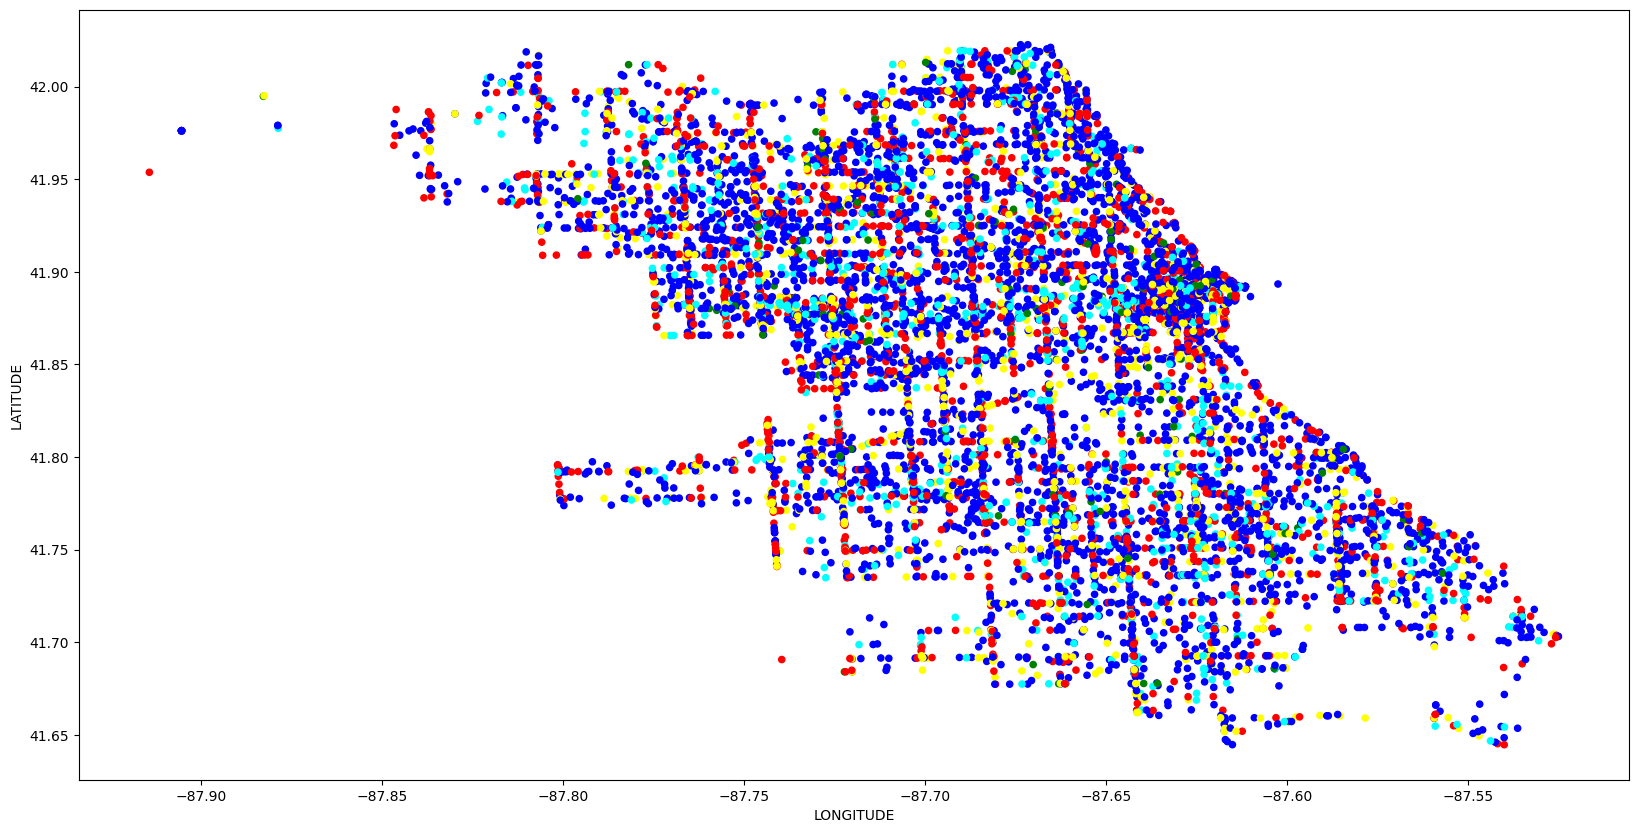